# Exercise session #2 - $k$-NN Classifier 

In this hands-on exercise you will implement your first machine learning
algorithm, the **$k$-Nearest Neighbor classifier ($k$-NN)**. You will also get familiar with
other very important concepts related to machine learning in practice,
including data preprocessing, distance metrics, visualization, and model evaluation.

We have provided general functionality and pointers for you here. Please complete the code with your own implementation below. Please also discuss and answer the follow-up questions.

### Dataset and problem description

The Healthy Body dataset contains body measurements acquired from **1250 people _from different ages, genders, and nationalities_** from different hospitals around the world. Health professionals have performed medical examinations and classified the individuals into three different body categories: **underweight, normal weight, and overweight.**

Our goal is to automate the role of the health professionals. However, due to anonymity reasons, we have been provided access to limited information about the individuals: their measured _weights_ and _heights_, and their respective _body category_ only.

We will use these features to train a $k$-NN classifier for the task.

---

In [1]:
# Enable interactive plots, so you can zoom/pan/resize plots
%matplotlib notebook

# Libraries for numerical handling and visualization. Install if required
import numpy as np
from matplotlib import pyplot as plt

### Data loading and visualization

The goal of supervised classification algorithms such as $k$-NN is to use information from a set of labeled examples, i.e., examples for which we know their class assignments, to infer the classes for unlabeled examples.

In [3]:
# Data loading

# Paths
features_annotated_path = "hbody_feats_annotated.npy"     # Weights, heights of individuals with known body category
labels_annotated_path = "hbody_labels_annotated.npy"      # Body categories of those individuals
features_unannotated_path = "hbody_feats_unannotated.npy" # Weights and heights of unknown body category individuals
                                                          # - Goal: Figure out their body categories

# Features organized in an NxD matrix; N examples, D features.
# Another way to look at it: each of the N examples is a D-dimensional feature vector.

features_annotated = np.load(features_annotated_path)
features_unannotated = np.load(features_unannotated_path)
labels_annotated = np.load(labels_annotated_path)

class_names = ('Underweight', 'Normal weight', 'Overweight')

**Q. What are the target variables? What are the predictor variables?**

- **Target variable:** Body category
- **Predictor variables:** weight, height

---

<IPython.core.display.Javascript object>


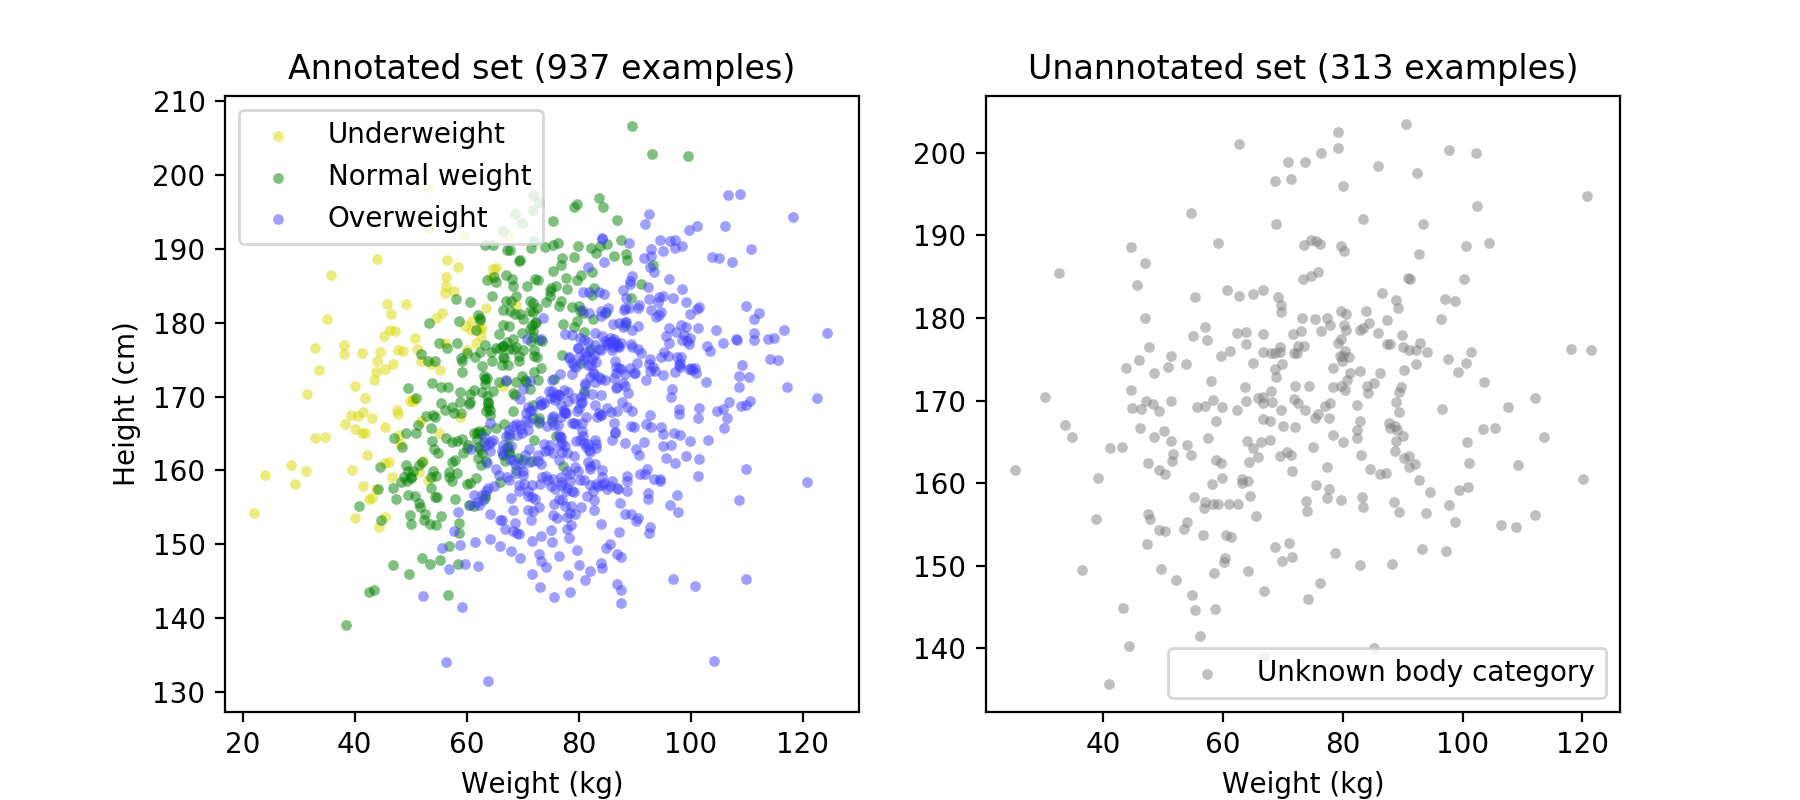

In [4]:
# Visualize annotated and unannotated sets

colors = np.array([[0.85, 0.85, 0], [0, 0.5, 0], [0.25, 0.25, 1]])

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title(f"Annotated set ({len(labels_annotated)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*features_annotated[labels_annotated==i].T,
                c=colors[i, None], alpha=0.5, s=15, lw=0, label=class_name)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.legend();

plt.subplot(1,2,2)
plt.title(f"Unannotated set ({len(features_unannotated)} examples)")
plt.scatter(*features_unannotated.T, c='gray', alpha=0.5, s=15, lw=0, label='Unknown body category')
plt.xlabel("Weight (kg)")
plt.legend();

**Q. Do you think this is an easy or a difficult classification problem? Why?**

> Should be an easy problem: under the two provided dimensions, different classes appear already easily separable.

**Q. What should the unannotated set share in common with the annotated set?**
> Rules learned on the annotated set will apply for new, unannotated data, provided that both sets are sampled from the same underlying distribution. In our example, we can have some evidence of this by visually comparing the point clouds of both annotated and unannotated data. They seem to have similar density of points for similar values. Note, however, that _because both the annotated and unannotated sets are [samples][1]_, they will not be perfectly representative of the underlying distribution, and some small differences are not only expected, but unavoidable.

[1]: https://en.wikipedia.org/wiki/Sample_(statistics)
---

## Splitting the annotated data into training, validation, and test sets

We need to ensure that our method generalizes, which means it will correctly predict the class for new provided examples.

In order to simulate this scenario, we will split our annotated data into two groups: the training set, and the test set.
- The **training set** will be used for finding a classification criterion, a.k.a. learning the model.
- The **test set** will be used for testing how well the learned model generalizes to data beyond that used for training.

While the training set helps us find out how exactly to manipulate our data to find the right prediction, the test set tells us how well we expect to perform when given new data. Our training procedure is allowed to handle data from the training set only, and should not in any way use the information from the test set.


### Cross-validation

If we are only allowed to assess our model generalization _after_ training, how can we monitor and guide the training process? How can we know beforehand that we are using the best version of our model?

The most common strategy for this, called **[cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))**, is, simply put, to pretend that a part of our training data is in fact unannotated, and see if our method manages to predict the annotations correctly. In other words, we will reserve a portion of our training data to temporarily act as a small test set. The simplest way to do this, called _holdout method_, is to extract a fixed amount of annotated data, called a **validation set**, to estimate the performance of our model in a test set, and to use the rest for training purposes. [Other types](https://www.cs.cmu.edu/~schneide/tut5/node42.html) of cross validation include k-fold cross validation, and leave-one-out cross validation.

Splitting your training data into a training and a validation set is also used for comparing different "versions" of your model. Many machine learning methods depend on predefined configuration settings, called _hyperparameters_, that heavily influence how the method behaves. In the case of $k$-NN, one such parameter is $k$, the number of neighbors.

**Q. How exactly do you think a validation set can be used for hyperparameter optimization?**

> Keeping an arbitrary but fixed set of examples allows for "fair" comparison of our model under different configurations. We use the same training data to train each hyperparameter configuration that we want to consider, and decide the best from its performance on the validation set.

In this exercise, we will be applying holdout cross validation. Technically, your validation set is part of your training data. To avoid confusion, however, we often call the _training set_ the portion of your training data used for tuning your method. Therefore, for holdout cross validation, we can split our annotated data into a training set, a validation set, and a test set.

**Q. Do you understand the difference between the validation set and the test set?**

> The validation set is used during the training process, and helps us make decisions about our model. The test set is **not** used during training, and does not affect training in any way. It is only used when we have tuned our model, to get an idea of how well our model generalizes to unseen data.

In [5]:
# Split labeled data into training, validation, and test set

np.random.seed(330)

# How much annotated data for training and validation. The rest is used for testing.
training_perc, validation_perc = 0.4, 0.1

indices = np.arange(len(labels_annotated))
np.random.shuffle(indices)

splits = (np.array([training_perc, validation_perc]) * len(labels_annotated)).astype(int).cumsum()

training_indices, validation_indices, test_indices = np.split(indices, splits)

training_features = features_annotated[training_indices]
training_labels = labels_annotated[training_indices]
validation_features = features_annotated[validation_indices]
validation_labels = labels_annotated[validation_indices]
test_features = features_annotated[test_indices]
test_labels = labels_annotated[test_indices]

**Q. What does `np.random.seed` do? Why is this useful?**

> `np.random.seed` resets the internal state of the random generator to a defined value. When randomization if required (as is the case here), this makes sure that we will get the same random ordering every time we run our entire program. This way, we can compare with our colleagues, and with previous versions of our code.

**Q. How should one select the size of the validation set?**

> There is no hard rule for this. Ideally, our validation set should be representative of the distribution that generates our data. In practice, this is very hard to measure. For situations where the annotated data is scarce, we have to try to find a balance between the amount of data used for training, so that we can learn good predicting rules, and the amount of data used for validation. Other cross-validation schemes help solve this to some extent.
 
**Q. What would be the most appropriate way to select examples for the validation set?**

> As stated above, the validation set should be representative of the distribution. By choosing examples randomly, that is to say, disregarding their ordering in the dataset, we avoid introducing biases that might come from the way the dataset has been processed.

## Normalizing data

$k$-NN determines neighbors by computing the "distance" between two examples. For this process to work, we are required
to normalize the features. This is true for many other machine learning algorithms as well.

**Q. What would happen if we don't do this?**

> Since originally both features (weights and heights) have different scales, the distance metric would implicitly give more importance to the feature with the largest scale. Unless we have a very good reason to do otherwise, we want to equally exploit the information from both features simultaneously, so we transform them to be in the same scale.

A very common way to normalize the data is by the so-called z-score standardization. It transforms values from an arbitrary range such that the result has mean $0$ and standard deviation $1$. The operation is defined as follows:

$$
x_{norm} = \frac {x - \mu_x} {\sigma_x},
$$
for _each feature independently_.

**Q. Why does this particular operation make sense?**

> This operation shifts the data, so that its center is 0, and then rescales the data, so that its variance is 1. By doing this, each feature directly tells us how far each example is from the average example, and how "extreme" the example is, or in other words, how far it is from the average example as compared with the rest of the examples.

**Q. What are the right $\mu_x$ and $\sigma_x$ to use? Why?**

> We are only allowed to infer parameters of our model from the training data. We have to compute $\mu_x$ and $\sigma_x$ from the training data only.

In [6]:
# Normalize the data.
# Tip: Use numpy's broadcasting to write your normalization function

def normalize(features, means, stds):
    return (features - means) / stds

mean_features = training_features.mean(axis=0)
std_features = training_features.std(axis=0)

norm_training_features = normalize(training_features, mean_features, std_features)
norm_validation_features = normalize(validation_features, mean_features, std_features)
norm_test_features = normalize(test_features, mean_features, std_features)

# Verify normalization
if np.allclose(norm_training_features.mean(axis=0), 0) and np.allclose(norm_training_features.std(axis=0), 1):
    print("Everything alright here.")
else:
    print("Nope. Try again.")
    
# Remember to use the normalized version of your data from here onwards.

Everything alright here.


<IPython.core.display.Javascript object>


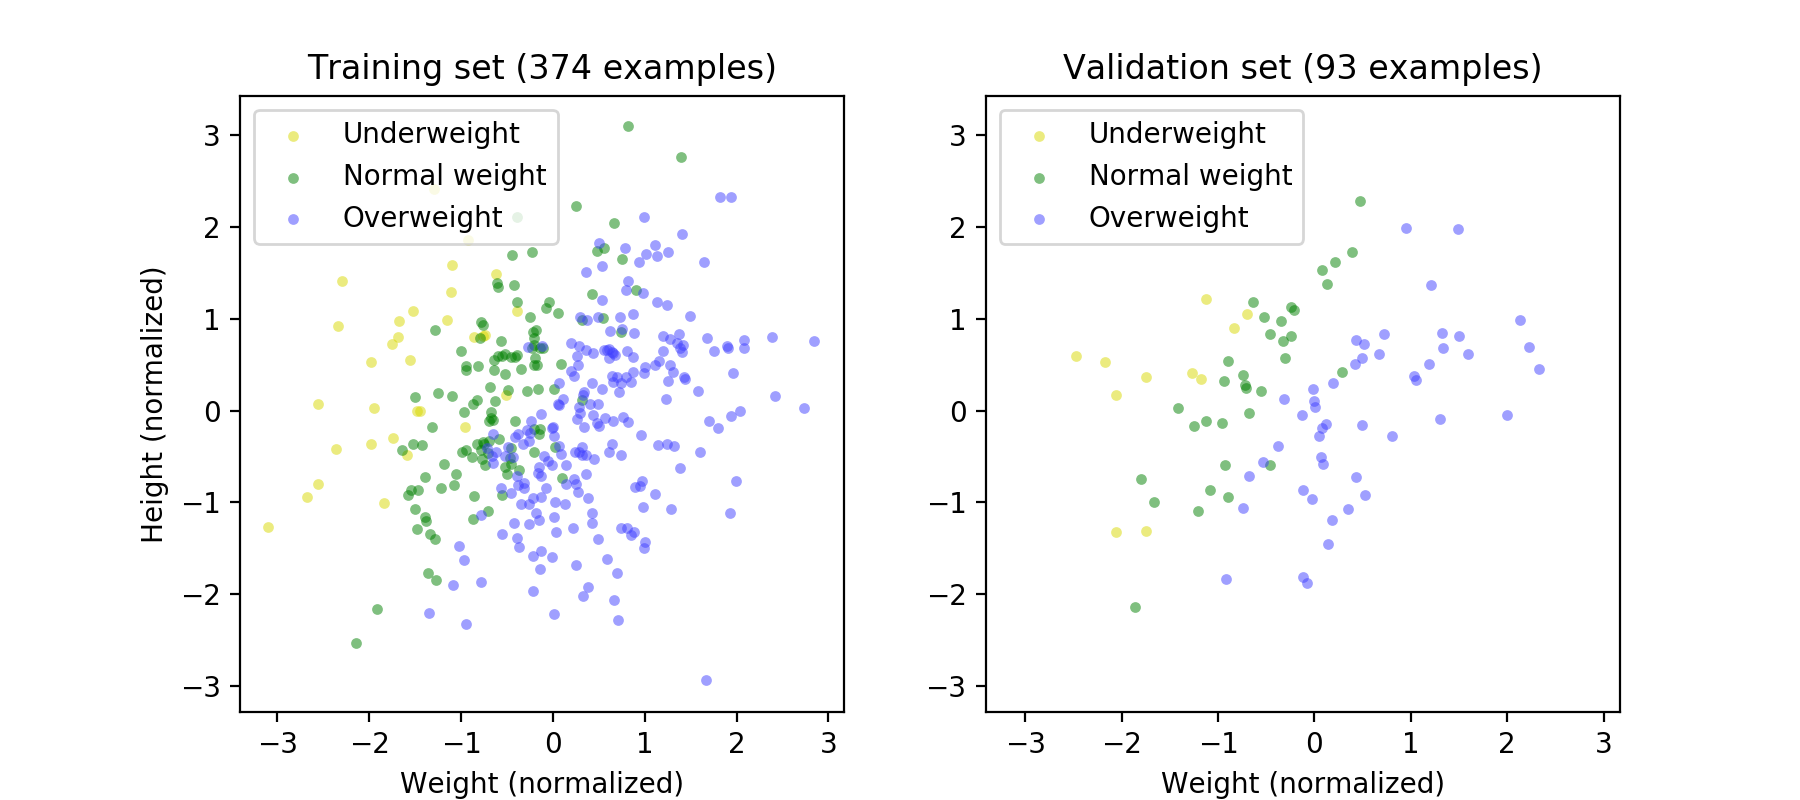

In [7]:
# Visualize training and validation data

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title(f"Training set ({len(training_labels)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_training_features[training_labels==i].T,
                c=colors[i, None], alpha=0.5, s=15, lw=0, label=class_name)
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.gca().set_aspect('equal')
xlims, ylims = plt.xlim(), plt.ylim()
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f"Validation set ({len(validation_labels)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_validation_features[validation_labels==i].T,
                c=colors[i, None], alpha=0.5, s=15, lw=0, label=class_name)
plt.xlabel("Weight (normalized)")
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend();

**Q. Is validation set representative of whole dataset?**

> It appears so:
> 1. They exhibit similar density overall (that is, disregarding the classes).
> 2. The relative representation of the classes is similar.

**Q. Notice that there is class imbalance. Would this be an issue?**

> The classes are decently separated, so we should be concerned mostly about what happens close to the boundary between classes. If there are enough neighbors to vote for each class close to this boundary we should be fine. The catch is, we cannot know beforehand how many neighbors we will need. Bottomline: depends on the problem.

---

## The $k$-Nearest Neighbors Classifier

$k$-NN assigns as label to a given example the most popular label from its surroundings. The method is very intuitive, and can be summarized as:
- Compute the distance between the example to classify and all the training examples.
- Select the closest $k$ training examples.
- Assign to the example the most common label among those neighbors.

### Distance metrics

There are many ways to define a distance between two examples. Two very common ones that we will use in this exercise are:

#### Euclidean distance:

$$
m(\mathbf{v}, \mathbf{w}) = \sqrt{ \sum_{i=1}^d \left(\mathbf{v}_i - \mathbf{w}_i\right)^2 }
$$

This is the generalization of the Pythagorean theorem to an arbitrary number of dimensions, and corresponds to our intuitive interpretation of the straight-line distance between two points.

#### Manhattan distance:

$$
m(\mathbf{v}, \mathbf{w}) = \sum_{i=1}^d |\mathbf{v}_i - \mathbf{w}_i|
$$

Aggregates differences in features independently from one another. It is also known as city block distance. One can think of it as the minimum distance one would have to walk between two intersections in a city organized by regular blocks.


**Q. Would you expect to find the same nearest neighbors to a point with both distance metrics?**

> Not in general. Some neighbors are further away under one metric than the other.

In [8]:
# Define a function to compute the euclidean distance between a vector and a collection of vectors (matrix)
# Tip: numpy's broadcasting allows you to write this in a very intuitive and simple way.
def euclidean_dist(example, training_examples):
    return np.sqrt(((training_examples - example) ** 2).sum(axis=1))

In [9]:
# Define a function to compute the euclidean distance between a vector and a collection of vectors (matrix)
def manhattan_dist(example, training_examples):
    return np.abs(training_examples - example).sum(axis=1)

### Let's dissect $k$-NN by classifying one example

Recall that the $k$-NN algorithm can be summarized as:
1. Compute the distance between an example to classify and all the training examples.
2. Select the closest $k$ training examples.
3. Assign to the example the most common label among those neighbors.

Let's get to it!

In [10]:
# For now, let's set k to an arbitrary value.
k = 7  # Number of neighbors to examine

In [11]:
# Pick a random example from the validation set
random_example_index = np.random.randint(len(norm_validation_features))
example = norm_validation_features[random_example_index]

<IPython.core.display.Javascript object>


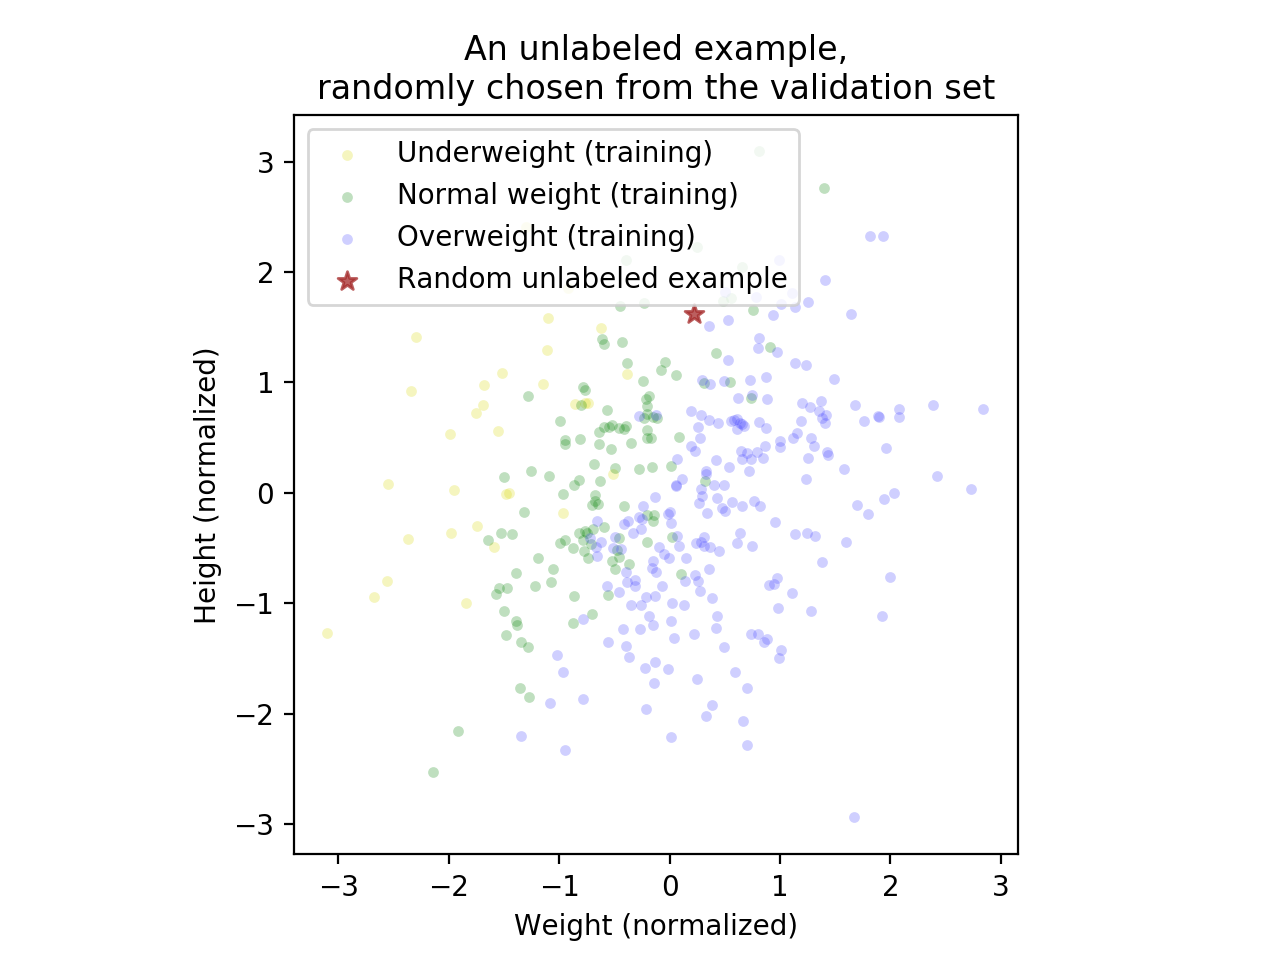

In [12]:
# Visualize the randomly chosen example in context

plt.figure()
plt.title("An unlabeled example,\nrandomly chosen from the validation set")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_training_features[training_labels==i].T,
                c=colors[i, None], alpha=0.25, s=15, lw=0, label=class_name + " (training)")

plt.scatter(*example, marker='*', c='brown', alpha=0.75, s=50, label='Random unlabeled example')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.gca().set_aspect('equal')
plt.legend();

**Q. What class would you assign to this example?**

> Looks like a normal weight person.

In [13]:
# Compute the euclidean distances between the chosen example and all the annotated examples
distances = euclidean_dist(example, norm_training_features)

In [14]:
# Find the indices of the k shortest distances from a list of distances
def find_k_nearest_neighbors(k, distances):
    indices = np.argsort(distances)[:k]
    return indices

In [15]:
# Find the k neighbors of the chosen example, and their respective labels
neighbor_indices = find_k_nearest_neighbors(k, distances)
neighbor_labels = training_labels[neighbor_indices]
print("\n".join(class_names[i] for i in neighbor_labels))

Overweight
Normal weight
Overweight
Overweight
Normal weight
Normal weight
Normal weight


<IPython.core.display.Javascript object>


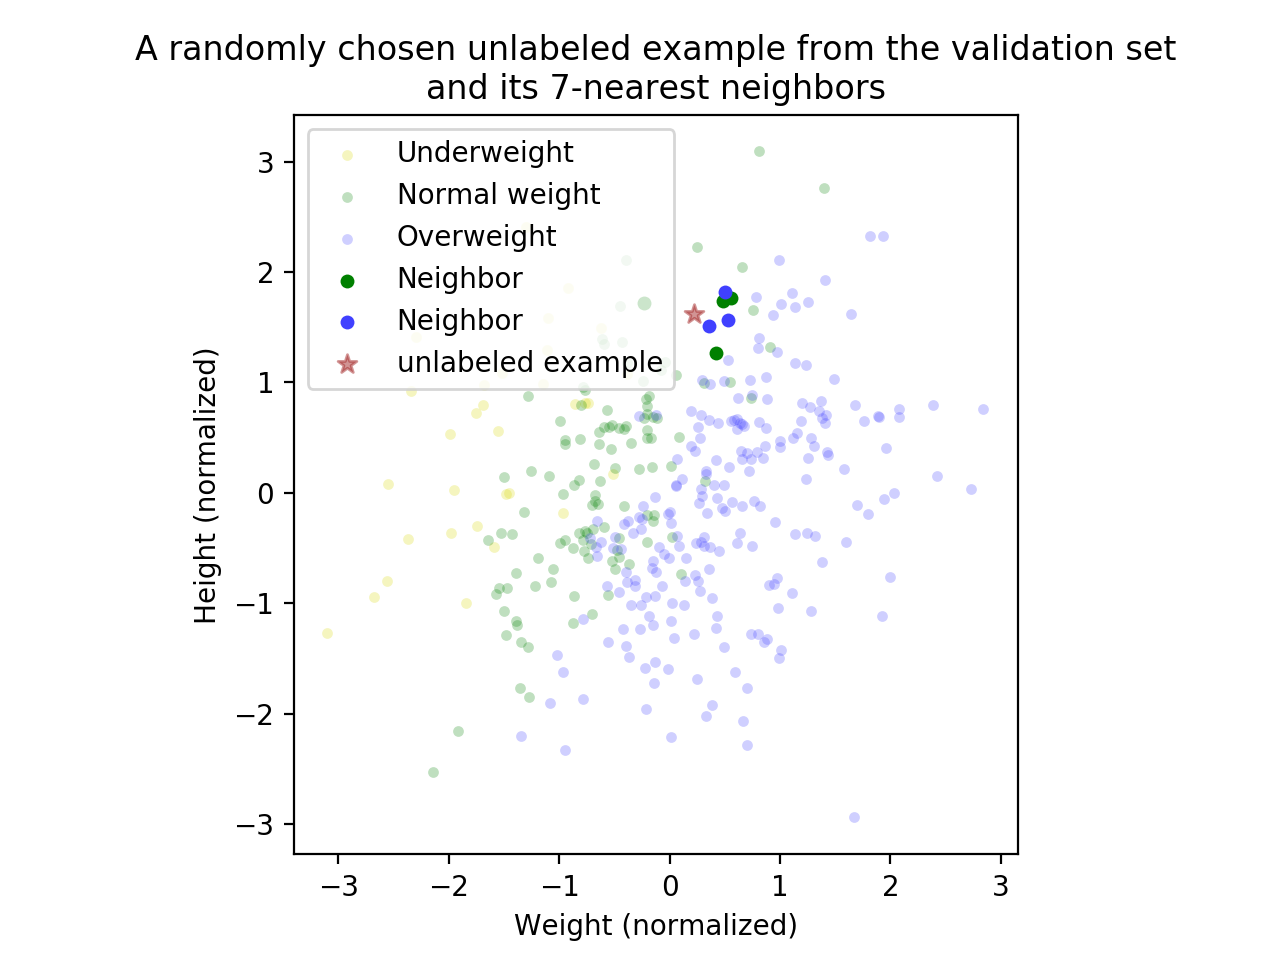

In [16]:
# Visualize neighbors

plt.figure()
plt.title(f"A randomly chosen unlabeled example from the validation set\nand its {k}-nearest neighbors")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_training_features[training_labels==i].T,
                c=colors[i, None], alpha=0.25, s=15, lw=0, label=class_name)
for i, class_name in enumerate(class_names):
    class_indices = neighbor_indices[training_labels[neighbor_indices] == i]
    if len(class_indices) > 0:
        plt.scatter(*norm_training_features[class_indices].T,
                    c=colors[i, None], alpha=1, s=25, lw=0, label='Neighbor')

ax = plt.scatter(*example, marker='*', c='brown', alpha=0.5, s=50, label='unlabeled example')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.gca().set_aspect('equal')
plt.legend();

**Q. What class would you assign to this example?**

> Still normal weight, but we see that it's close to some overweight people. Now it's harder to tell.

**Q. What class would $k$-NN assign to this example?**

> The count gave us 4 out of 7 neighbors as normal weight. $k$-NN class is Normal weight.

In [17]:
# Given a list of neighbor labels, choose the most popular.
# Tip: np.bincount is your friend.

def predict_label(neighbor_labels):
    return np.argmax(np.bincount(neighbor_labels))

In [18]:
# Get the label suggested by the example's neighbors
example_label = predict_label(neighbor_labels)

<IPython.core.display.Javascript object>


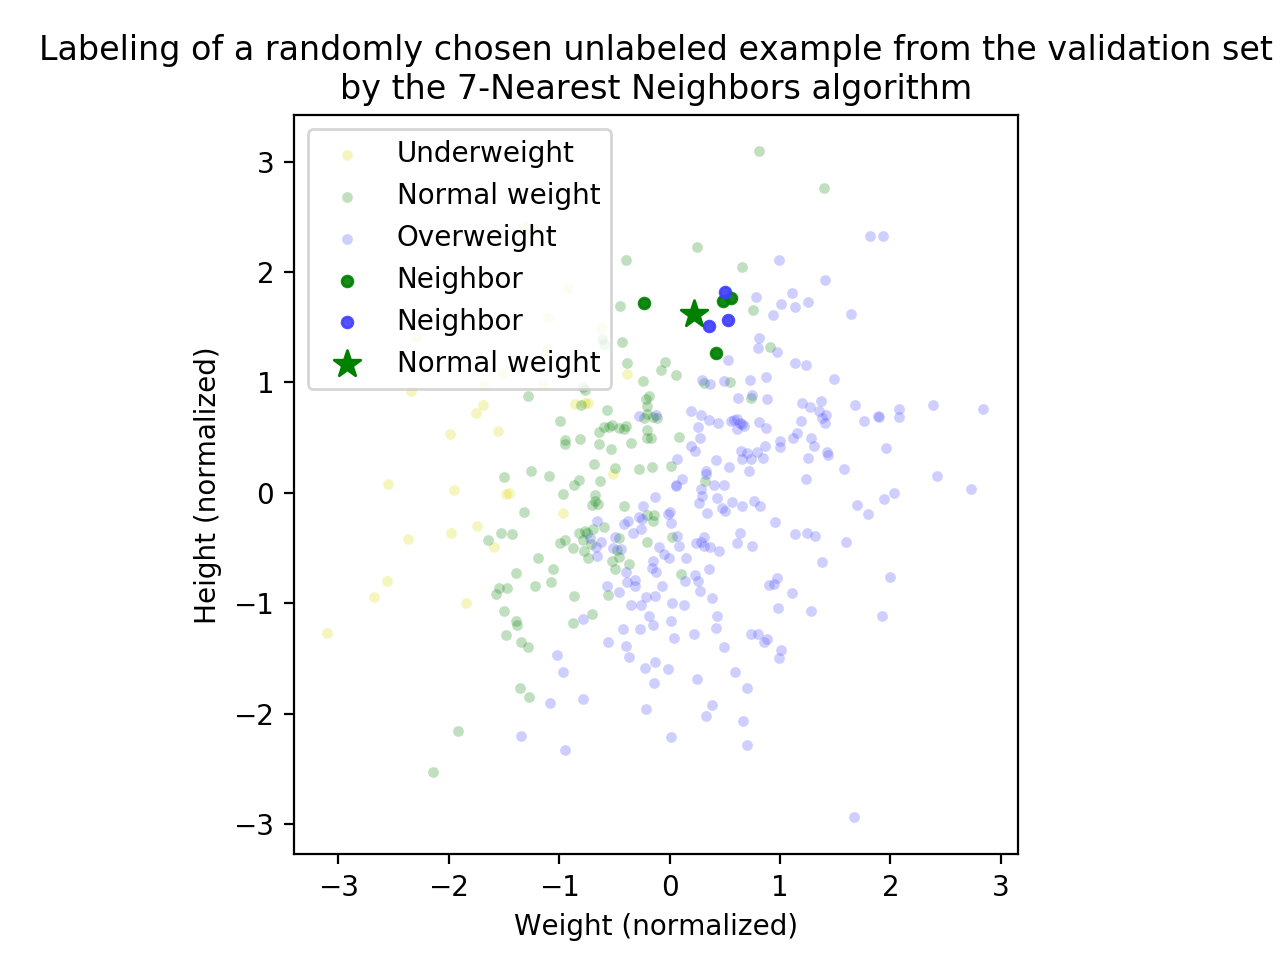

In [19]:
# Visualize prediction

plt.figure()
plt.title(f"Labeling of a randomly chosen unlabeled example from the validation set\nby the {k}-Nearest Neighbors algorithm")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_training_features[training_labels==i].T,
                c=colors[i, None], alpha=0.25, s=15, lw=0, label=class_name)
for i, class_name in enumerate(class_names):
    class_indices = neighbor_indices[training_labels[neighbor_indices] == i]
    if len(class_indices) > 0:
        plt.scatter(*norm_training_features[class_indices].T,
                    c=colors[i, None], alpha=.9, s=15, lw=1, label='Neighbor')

ax = plt.scatter(*example, marker='*', c=colors[example_label, None], alpha=1, s=100, label=class_names[example_label])
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.gca().set_aspect('equal')
plt.legend();

**Q. How would the $k$-NN algorithm change if we had more than two dimensions?**

> Notice that the definition of the distance metrics is not restricted to a specific number of dimensions. The other operation that we perform is counting neighbors. No changes required.

### Putting it all together

In [20]:
# Write a function kNN_one_example that applies all the previous steps
# to predict the label of one example.

def kNN_one_example(unlabeled_example, training_features, training_labels, k):
    distances = euclidean_dist(unlabeled_example, training_features)  # Compute distances
    nn_indices = find_k_nearest_neighbors(k, distances)               # Find neighbors
    neighbor_labels = training_labels[nn_indices]                     # Get neighbors' labels
    best_label = predict_label(neighbor_labels)                       # Pick the most common
    
    return best_label

In [21]:
# Write a function kNN that applies kNN_one_example to an arbitrary number of examples.
# Tip: numpy's apply_along_axis does most of the work for you.

def kNN(unlabeled, training_features, training_labels, k):
    return np.apply_along_axis(kNN_one_example, 1, unlabeled, training_features, training_labels, k)

**Q. While the above implementation works, it has some drawbacks. Can you identify them?**

> Biggest issue is that we compute the distances from each example at a time.

**Q. Can you think of a better implementation?**

> It is possible to compute all-to-all distances in one run by using numpy views and broadcasting.

In [22]:
# Use the function you just defined to predict the labels of all examples from the validation set.
predicted_labels = kNN(norm_validation_features, norm_training_features, training_labels, k)

<IPython.core.display.Javascript object>


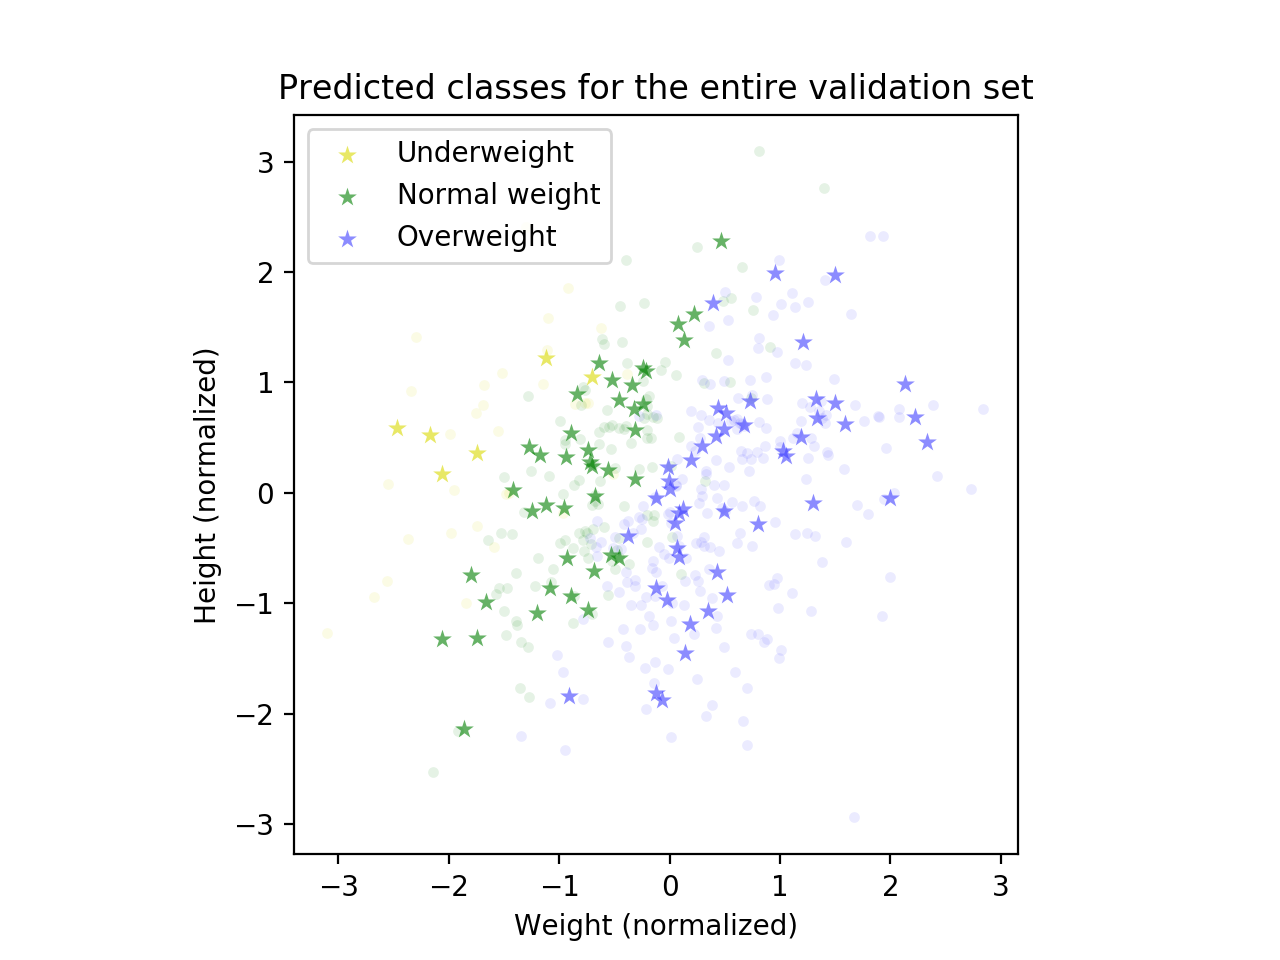

In [23]:
# Visualize the results.

plt.figure()
plt.title("Predicted classes for the entire validation set")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_training_features[training_labels==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_validation_features[predicted_labels==i].T,
                c=colors[i, None], marker='*', alpha=0.6, s=50, lw=0, label=class_name)
plt.gca().set_aspect('equal')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

### But... how do we know this prediction is good?

In order to quantify the performance of our model, we want to obtain a score that tells us how close the predictions were to the expected classification.

The simplest way to do this is to compute the ratio of correctly predicted examples, also known as the accuracy:

$$
\frac 1 N \sum_{n=1}^N \mathbf{1}[\hat{y} \neq y]
$$

**Q. Do you see any limitation to using accuracy to evaluate your model?**

> We do not care _what_ particular mistakes the model made. One can argue that incorrectly labeling an overweight person as underweight is worse than labeling them as normal weight.
> Also, if most people belonged to one class, just predicting that class for the whole population would give a very high accuracy. Plain accuracy does not account for class imbalances

**Q. Can you think of other ways to evaluate your model?**

> There are many. Qualitatively, one could inspect what mistakes the model made, by computing a confusion matrix: a matrix with counts of all the predictions and expected labels. One could improve the accuracy metric by assigning weights to each example related to its class frequency: the more uncommon a class is, the more important it is that the model classifies the example as belonging to such class.
>
> Find a nice summary and discussion of popular metrics [here][1].

[1]: https://www.quora.com/What-are-some-good-error-metrics-for-multi-class-classification-when-you-have-many-objects-to-classify

In [24]:
# Write a function that computes the accuracy between a prediction and the expected labels.
def accuracy(predicted, target):
    return np.mean(predicted == target)

In [25]:
# How well did your classifier perform?

performance = accuracy(validation_labels, predicted_labels)
print(f"{k}-NN Classifier predicted correctly {performance:.2%} of the validation examples.")

7-NN Classifier predicted correctly 88.17% of the validation examples.


**Q. Is accuracy suitable for multiclass classification?**

> Plain accuracy is not as suitable as other metrics for multiclass classification.

**Q. What other criteria, aside from accuracy, should one consider when choosing hyperparameters?**

> One other criterion is model complexity. When possible, one should choose simpler models over more complicated ones. Other criteria include robustness, speed, and scalability. Find more info [here][1].

[1]: https://www.teradata.com/Blogs/Occam%E2%80%99s-razor-and-machine-learning

## Hyperparameter optimization

Did we choose the best $k$?

We can evaluate our model under different values of $k$ to compare them. A simple way to do it is to evaluate our model's predictions for the same validation set when using different values of $k$.

**Q. Why should we use the same validation set for all cases?**

> Otherwise the comparison would not be as meaningful, as every case would be exposed to different sampling bias.

**Q. What problems can we face by doing this?**

> We risk choosing a hyperparameter configuration that is suboptimal for model generalization.

In [26]:
# Compute the evaluation metric for different values of k

model_performace_validation = []  # Store the computed metrics here
k_values = range(1, 21)           # Try these values for hyperparameter k
for k in k_values:
    predicted_labels = kNN(norm_validation_features, norm_training_features, training_labels, k)
    model_performace_validation.append(accuracy(predicted_labels, validation_labels))

<IPython.core.display.Javascript object>


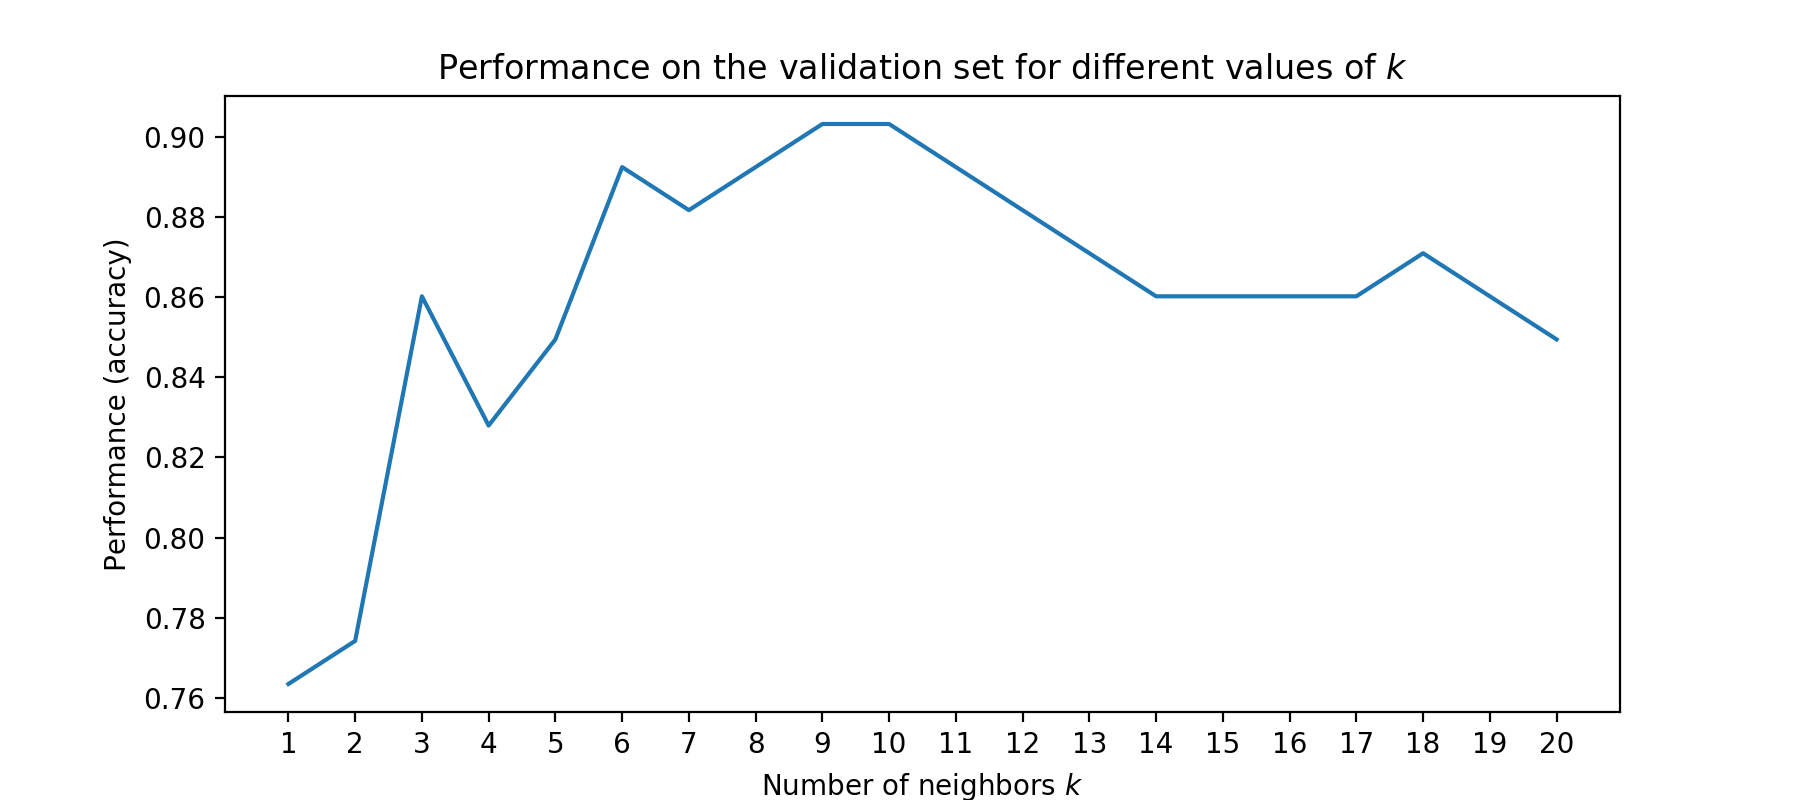

In [27]:
# Visualize the performances for different values of k

plt.figure(figsize=(9,4))
plt.title("Performance on the validation set for different values of $k$")
plt.plot(k_values, model_performace_validation)
plt.xlabel("Number of neighbors $k$")
plt.xticks(k_values)
plt.ylabel("Performance (accuracy)");

In [28]:
# Pick hyperparameter value that yields the best performance
best_k = k_values[np.argmax(model_performace_validation)]

print(f"Best number of neighbors on validation set is k={best_k}")

Best number of neighbors on validation set is k=9


### Does your final model generalize?

Now that we have tuned our model, we can apply it for prediction on the test set.

**Q. How do you expect the model to perform, compared with the validation set performance?**

> If our validation set is representative of the underlying distribution, we can expect accurate predictions. How accurate they are will depend on the problem. Usually due to sampling bias in the training and validation sets, we can expect slightly lower results on the test set.

In [29]:
predicted_test_labels = kNN(norm_test_features, norm_training_features, training_labels, best_k)

<IPython.core.display.Javascript object>


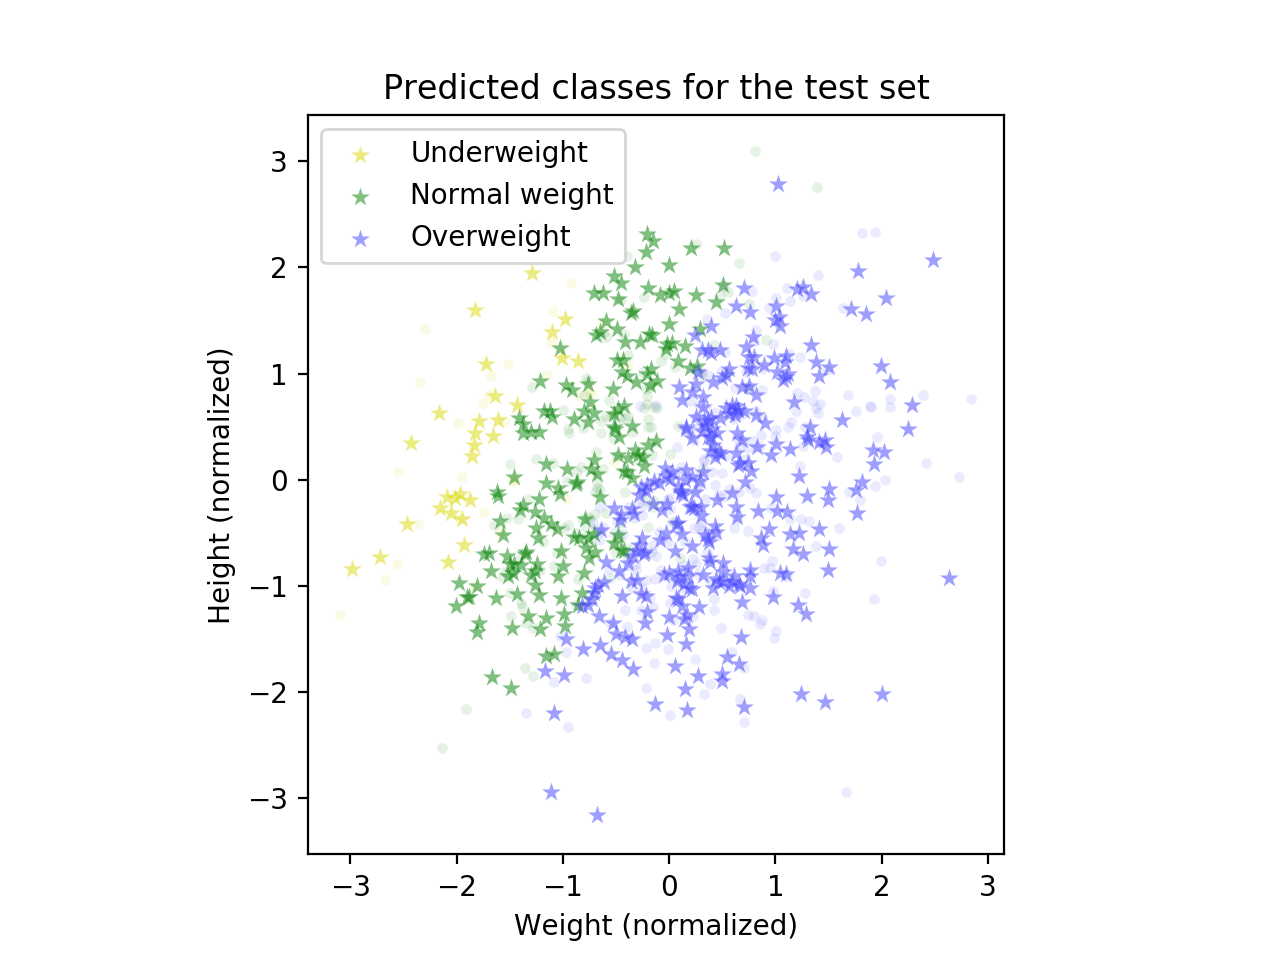

In [30]:
# Visualize the predictions on the test set

plt.figure()
plt.title("Predicted classes for the test set")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_training_features[training_labels==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_test_features[predicted_test_labels==i].T,
                c=colors[i, None], marker='*', alpha=0.5, s=50, lw=0, label=class_name)
plt.gca().set_aspect('equal')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

In [31]:
performance = accuracy(test_labels, predicted_test_labels)
print(f"{best_k}-NN Classifier predicted correctly {performance:.2%} of the test examples.")

9-NN Classifier predicted correctly 84.68% of the test examples.


**Q. Was this the value you were expecting?**

> The predictions visually seem consistent with what one would expect. Since the metric used here is not ideal for multiclass classification, it should not be alarming that the value is lower than the one obtained from the validation set.

### Predicting on unannotated data

We are finally ready to apply our model for prediction on unannotated data.

In [32]:
# Data loading and preparation
features_unannotated = np.load(features_unannotated_path)

norm_features_unannotated = normalize(features_unannotated, mean_features, std_features)

**Q. What should one take into account when feeding new data to a machine learning model?**

> Same distribution assumption. This in practice also means that any transformation we applied on the training data, such as the data normalization operation that we applied above, should be applied in the same way to all the rest of the data.

In [33]:
# Get predictions for unlabeled data.
predicted_labels_unannotated = kNN(norm_features_unannotated, norm_training_features, training_labels, best_k)

<IPython.core.display.Javascript object>


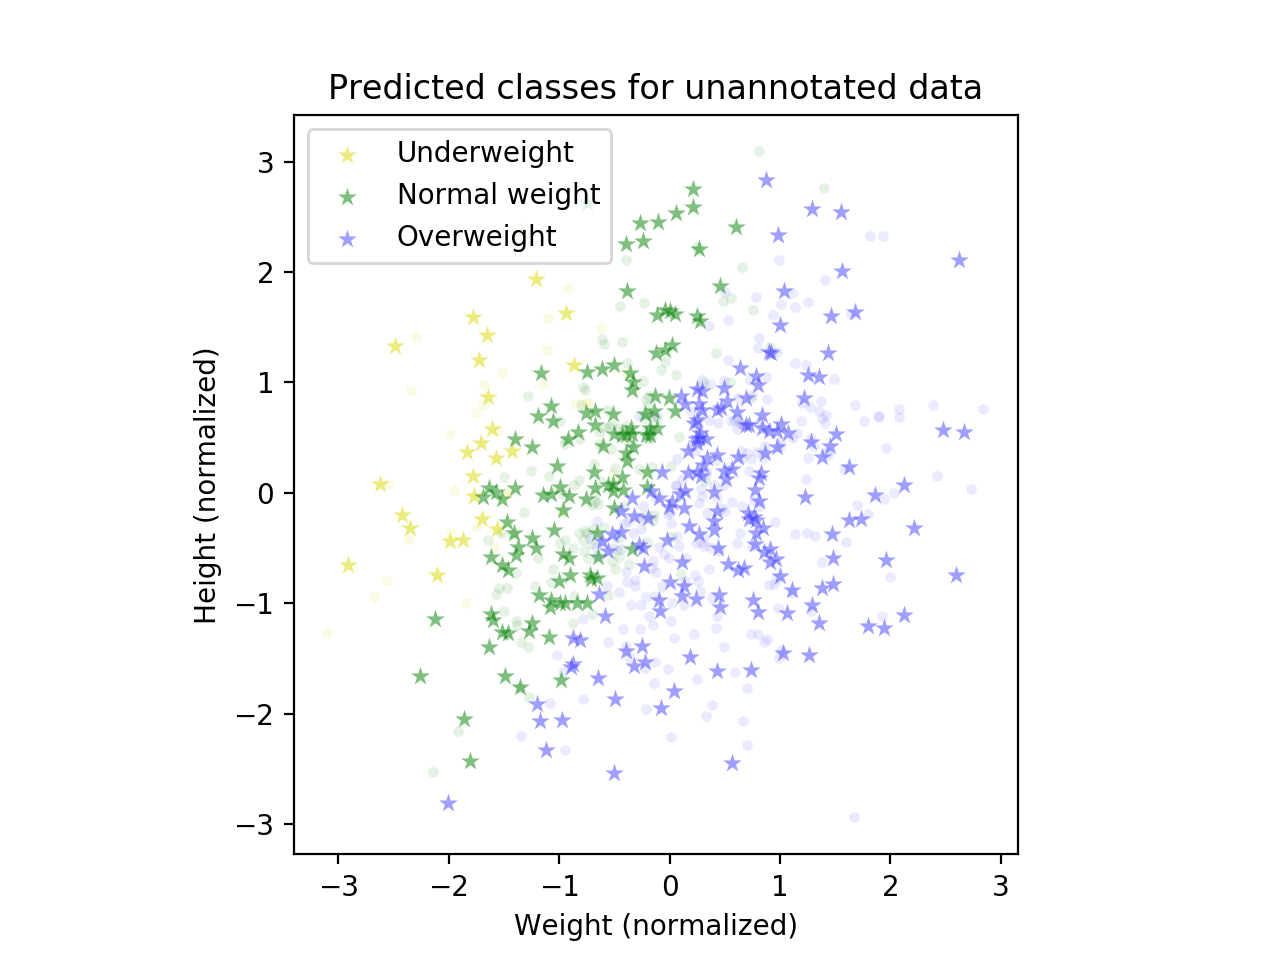

In [34]:
# Visualize the predictions on the test set

plt.figure()
plt.title("Predicted classes for unannotated data")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_training_features[training_labels==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_features_unannotated[predicted_labels_unannotated==i].T,
                c=colors[i, None], marker='*', alpha=0.5, s=50, lw=0, label=class_name)
plt.gca().set_aspect('equal')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

**Q. Do these class assignments look reasonable to you?**

> Yes.

**Q. How would you evaluate if your predictions are reasonable here, without labels?**

> One idea could be to compare the predicted class frequencies with the class frequencies of the training data.

# A multidimensional dataset

Let's try to apply what we have learned on a different dataset.

The Iris dataset quantifies the morphologic variation of [Iris flowers](https://en.wikipedia.org/wiki/Iris_(plant)) of three related species: _Iris setosa_, _Iris versicolor_, and _Iris virginica_. The dataset contains measurements of the length and the width of the sepals and petals, in centimeters, of different flowers from the three different species.

Your goal is to train and apply the $k$-NN algorithm to this multiclass classification problem. You are encouraged to reuse the functions that you wrote for the previous exercise.

In [35]:
# Dataset path

iris_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_class_names = ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica')
iris_feature_names = ("Sepal length", "Sepal width", "Petal length", "Petal width")

# Load data

def iris_label_converter(string_class):
    """ Converts labels from their string representation to a numerical value."""
    return iris_class_names.index(string_class)

iris_data = np.loadtxt(iris_path, delimiter=',', converters={4: iris_label_converter}, encoding='latin1')

iris_features, iris_labels = np.split(iris_data, [-1], axis=1)
iris_labels = iris_labels.flatten().astype(int)

### (very minimal) Exploratory data analysis

In order to make yourself familiar with the main characteristics of the dataset, let's visualize the pairwise interactions between features.

<IPython.core.display.Javascript object>


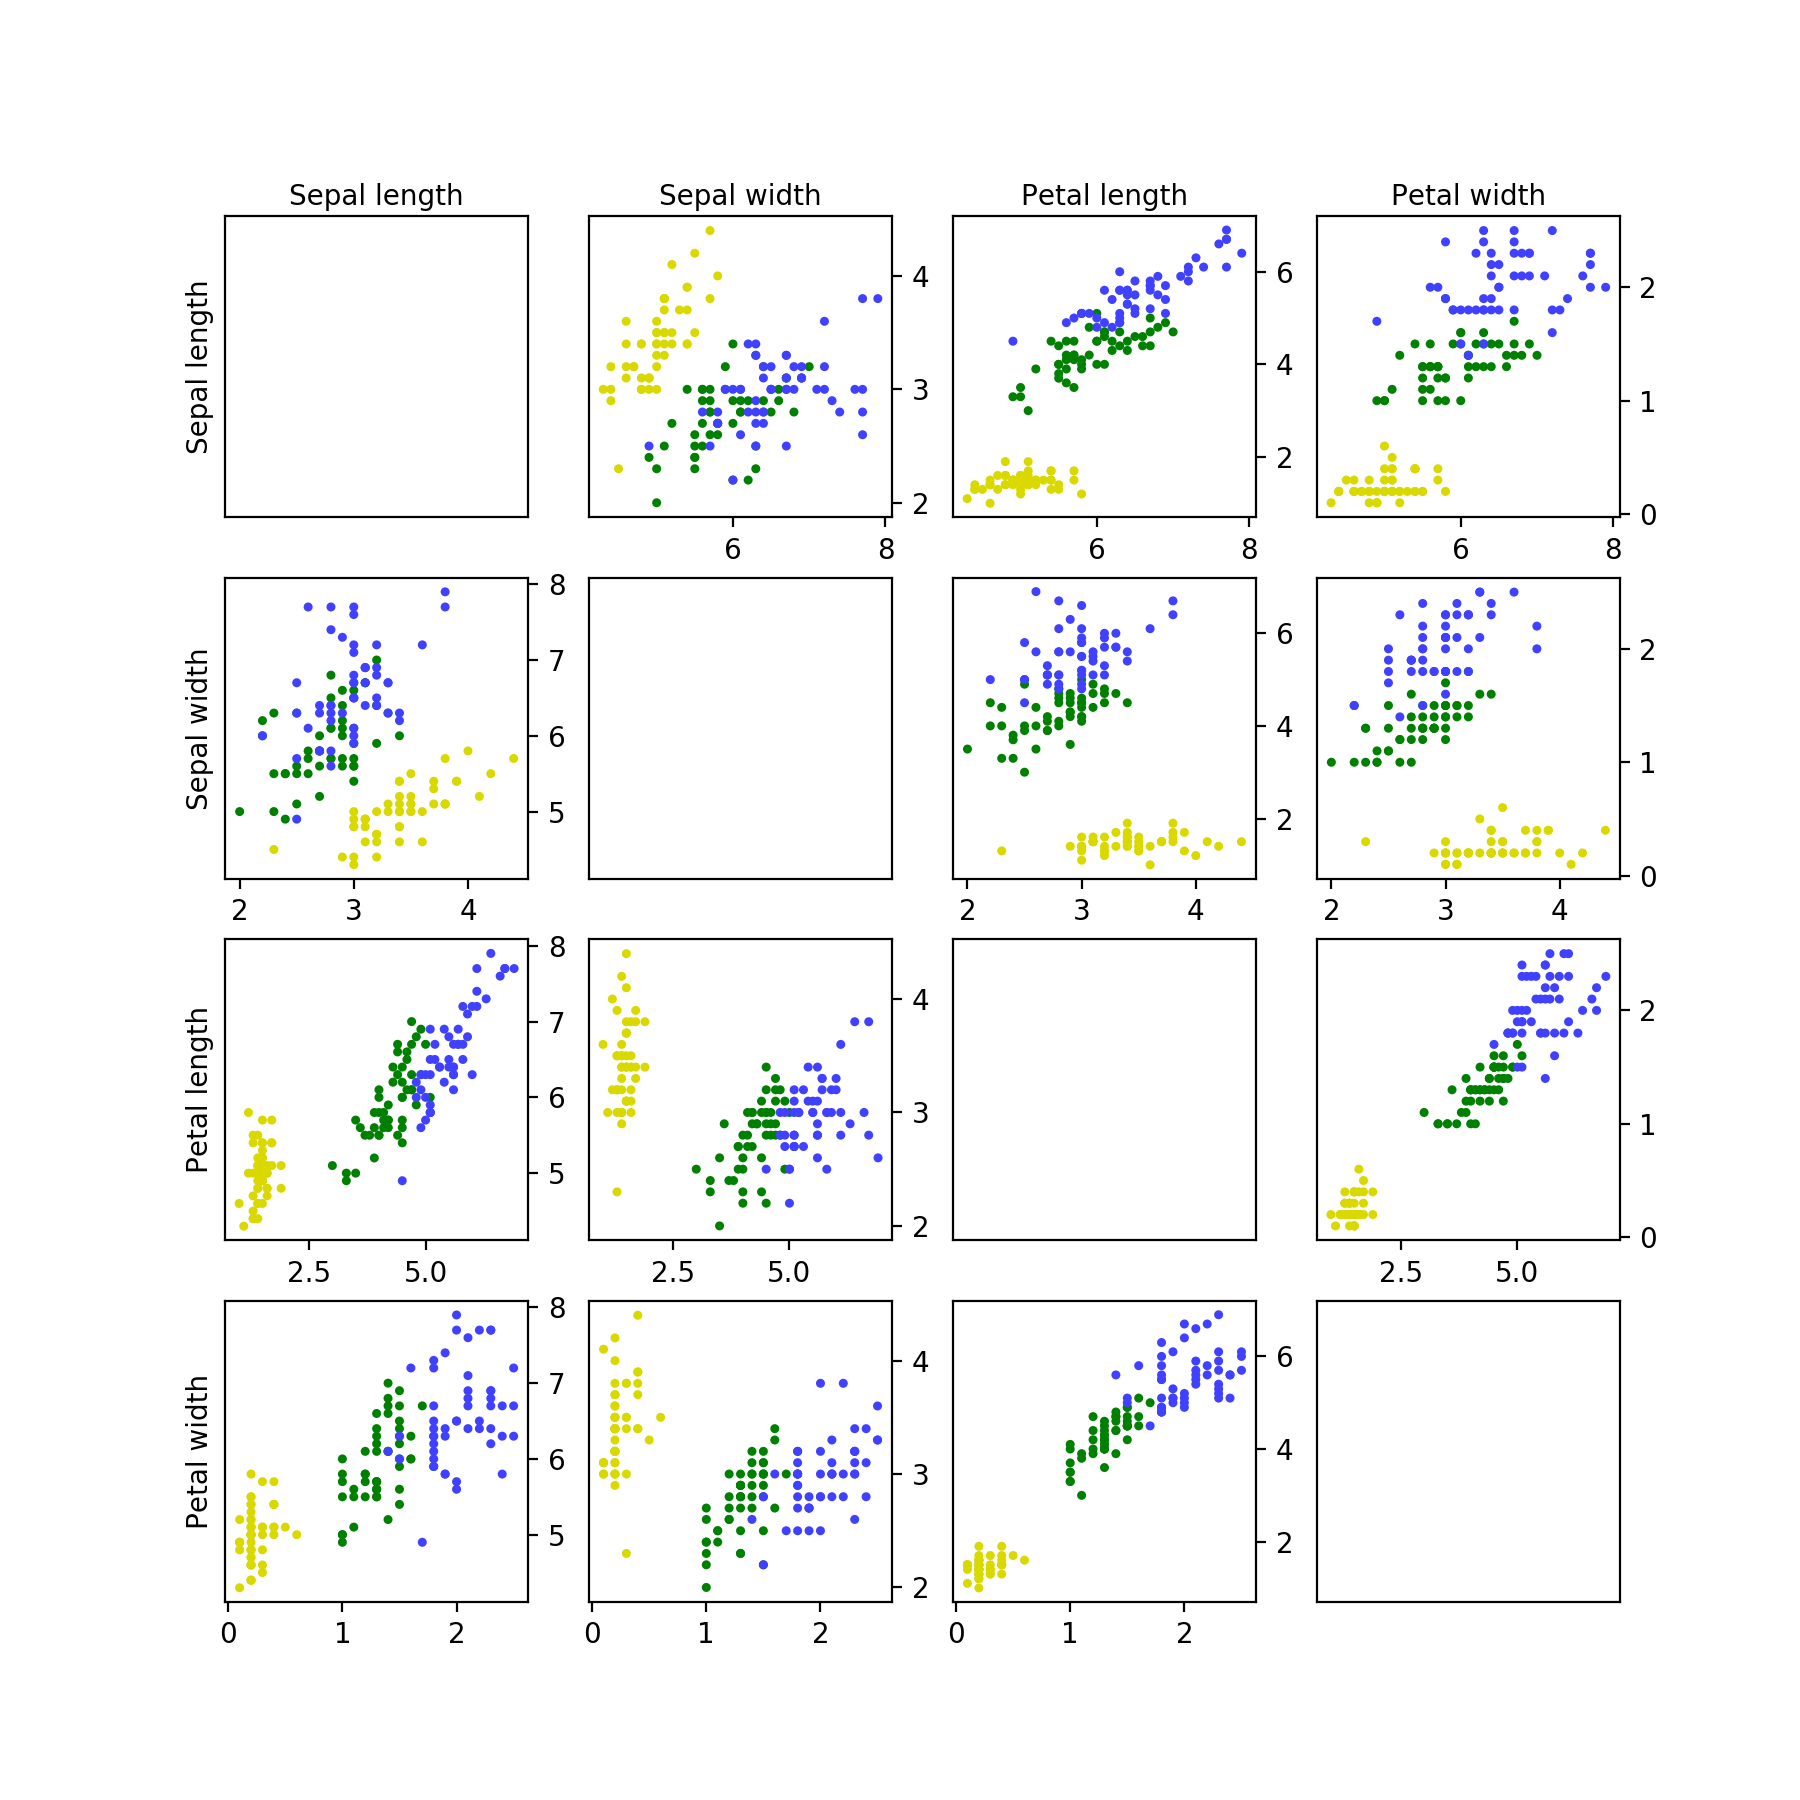

In [36]:
# Plot all possible pairs of features.
# Use matplotlib's subplot to arrange those plots on a grid.

plt.figure(figsize=(9, 9))
d = iris_features.shape[1]
for i in range(d):
    for j in range(d):
        plt.subplot(d, d, i * iris_features.shape[1] + j + 1)
        if j == 0:
            plt.ylabel(iris_feature_names[i])
        if i == 0:
            plt.xlabel(iris_feature_names[j])
            plt.gca().xaxis.set_label_position('top') 
        if i == j:
            plt.xticks([]),plt.yticks([])
        else:
            plt.scatter(iris_features[:, i], iris_features[:, j], c=colors[iris_labels], s=5)
            plt.gca().yaxis.tick_right()

**Q. Can you draw preliminary conclusions about the data?**

> There are some combinations of features that hint to linear separability.

**Q. Do you think this is an easy or a difficult classification problem? Why?**

> For some feature combinations, points belonging to the same class are tightly clustered together and don't overlap much. Data looks largely linearly-separable. Seems not hard.

In [37]:
# Split data into training, validation, and test data
np.random.seed(476)

perc_training = 0.3
perc_validation = 0.2
perc_testing = 0.5

indices = np.arange(len(iris_labels))
np.random.shuffle(indices)

split_at = (np.cumsum([perc_training, perc_validation]) * len(iris_labels)).astype(int)

training_indices, validation_indices, test_indices = np.split(indices, split_at, axis=0)

iris_training_features = iris_features[training_indices]
iris_training_labels = iris_labels[training_indices]

iris_validation_features = iris_features[validation_indices]
iris_validation_labels = iris_labels[validation_indices]

iris_testing_features = iris_features[test_indices]
iris_testing_labels = iris_labels[test_indices]

### Apply $k$-NN
Train a k-NN classifier, and use it to predict the classes on the testing set.

You should know what to do from here on.

In [38]:
# Data normalization

means = iris_training_features.mean(axis=0)
stds = iris_training_features.std(axis=0)
iris_training_features = normalize(iris_training_features, means, stds)
iris_validation_features = normalize(iris_validation_features, means, stds)
iris_testing_features = normalize(iris_testing_features, means, stds)

<IPython.core.display.Javascript object>


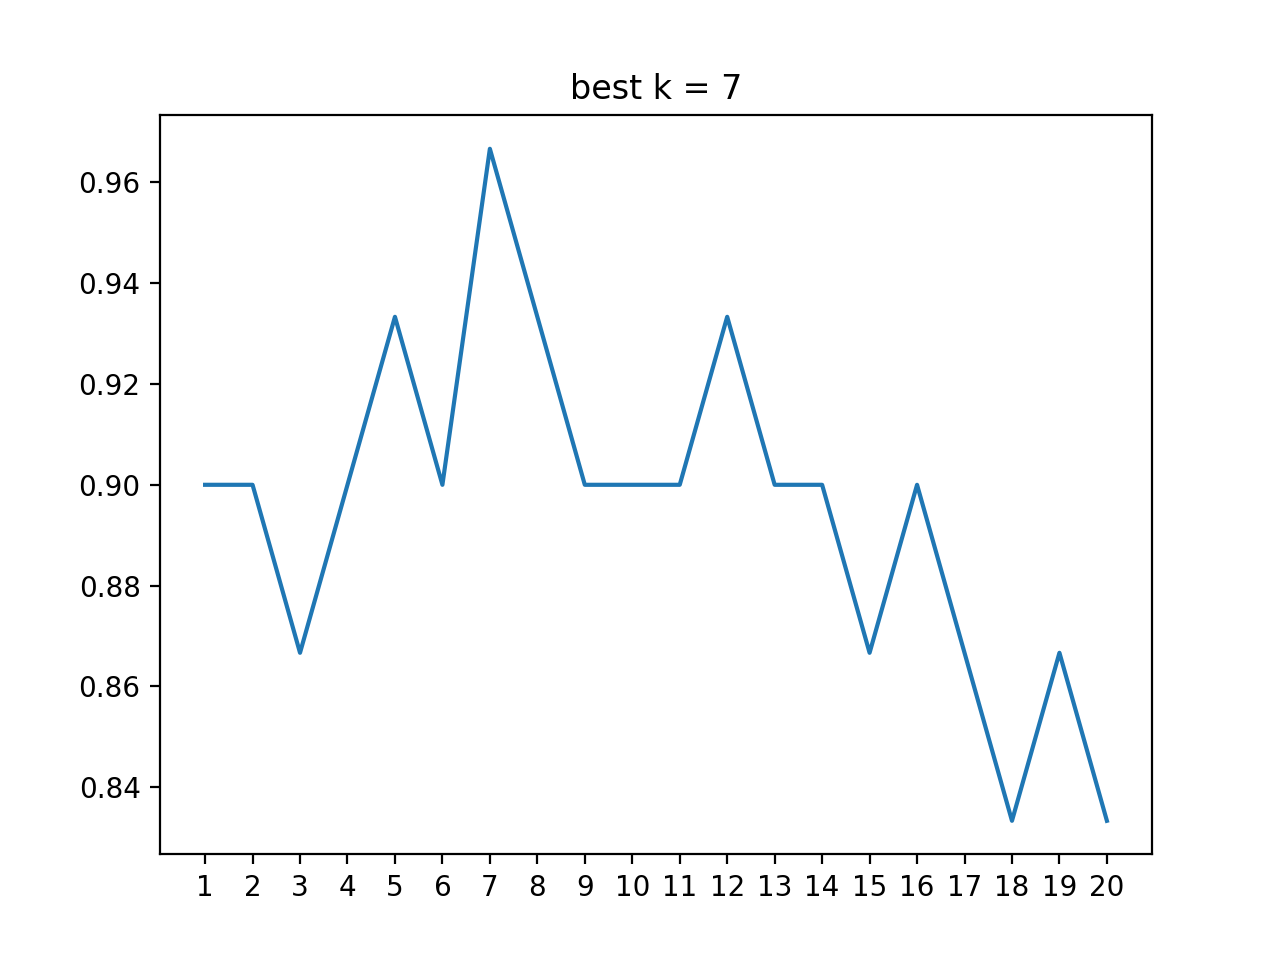

In [39]:
# Hyperparameter optimization

k_to_try = range(1, 21)
validation_acc = [accuracy(kNN(iris_validation_features, iris_training_features, iris_training_labels, k=k_i),
                           iris_validation_labels)
                  for k_i in k_to_try]
plt.figure()
plt.plot(k_to_try, validation_acc)
plt.xticks(k_to_try)
best_k = k_to_try[np.argmax(validation_acc)]
plt.title(f"best k = {best_k}".format());

In [40]:
# Prediction on the test set
iris_testing_prediction = kNN(iris_testing_features, iris_training_features, iris_training_labels, k=best_k)

In [41]:
# Evaluation on the test set (remember this is only possible because this is a toy example.)
iris_testing_performance = accuracy(iris_testing_prediction, iris_testing_labels)
print(f"{best_k}-NN Classifier predicted correctly {iris_testing_performance:.2%} of the test examples.")

7-NN Classifier predicted correctly 92.00% of the test examples.


### A closer look at the predictions

Let's see what our classifier got right and what it got wrong.

<IPython.core.display.Javascript object>


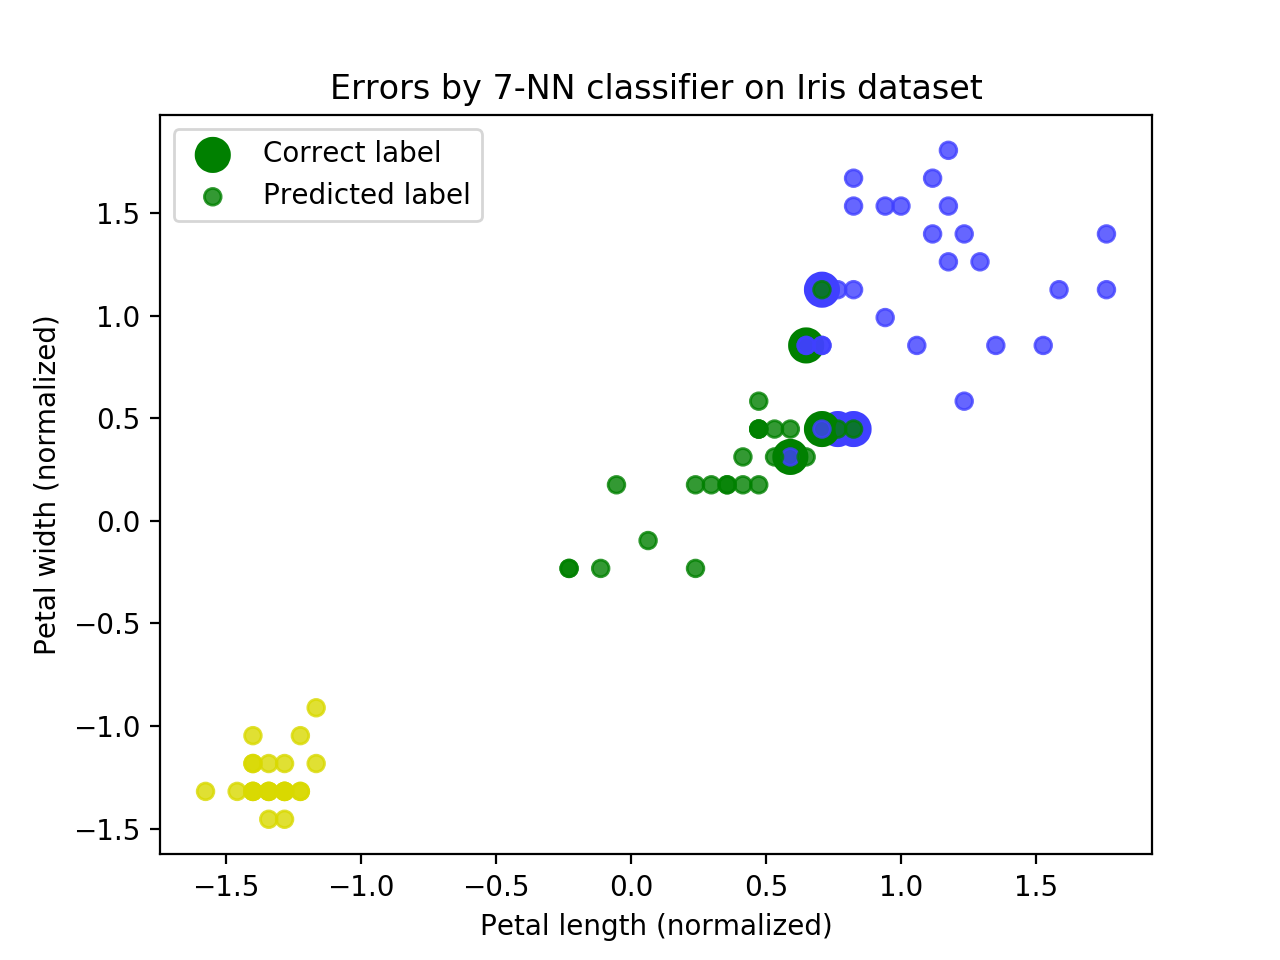

In [42]:
# Create a plot of the Petal length vs Petal width
# Highlight the examples where your classifier failed.

incorrect_predictions = (iris_testing_prediction != iris_testing_labels)
selected_features = (2, 3)

plt.figure()
plt.title(f"Errors by {best_k}-NN classifier on Iris dataset")
plt.scatter(*iris_testing_features[incorrect_predictions][:, selected_features].T,
            c=colors[iris_testing_labels[incorrect_predictions]], lw=7, label='Correct label')
plt.scatter(*iris_testing_features[:, selected_features].T,
            c=colors[iris_testing_prediction], alpha=0.8, label='Predicted label')
plt.xlabel(iris_feature_names[selected_features[0]] + " (normalized)")
plt.ylabel(iris_feature_names[selected_features[1]] + " (normalized)")
plt.legend();

**Q. Do misclassifications occur where you would expect?**

> Yes, it's reasonable to make mistakes close to the boundary between classes.

<IPython.core.display.Javascript object>


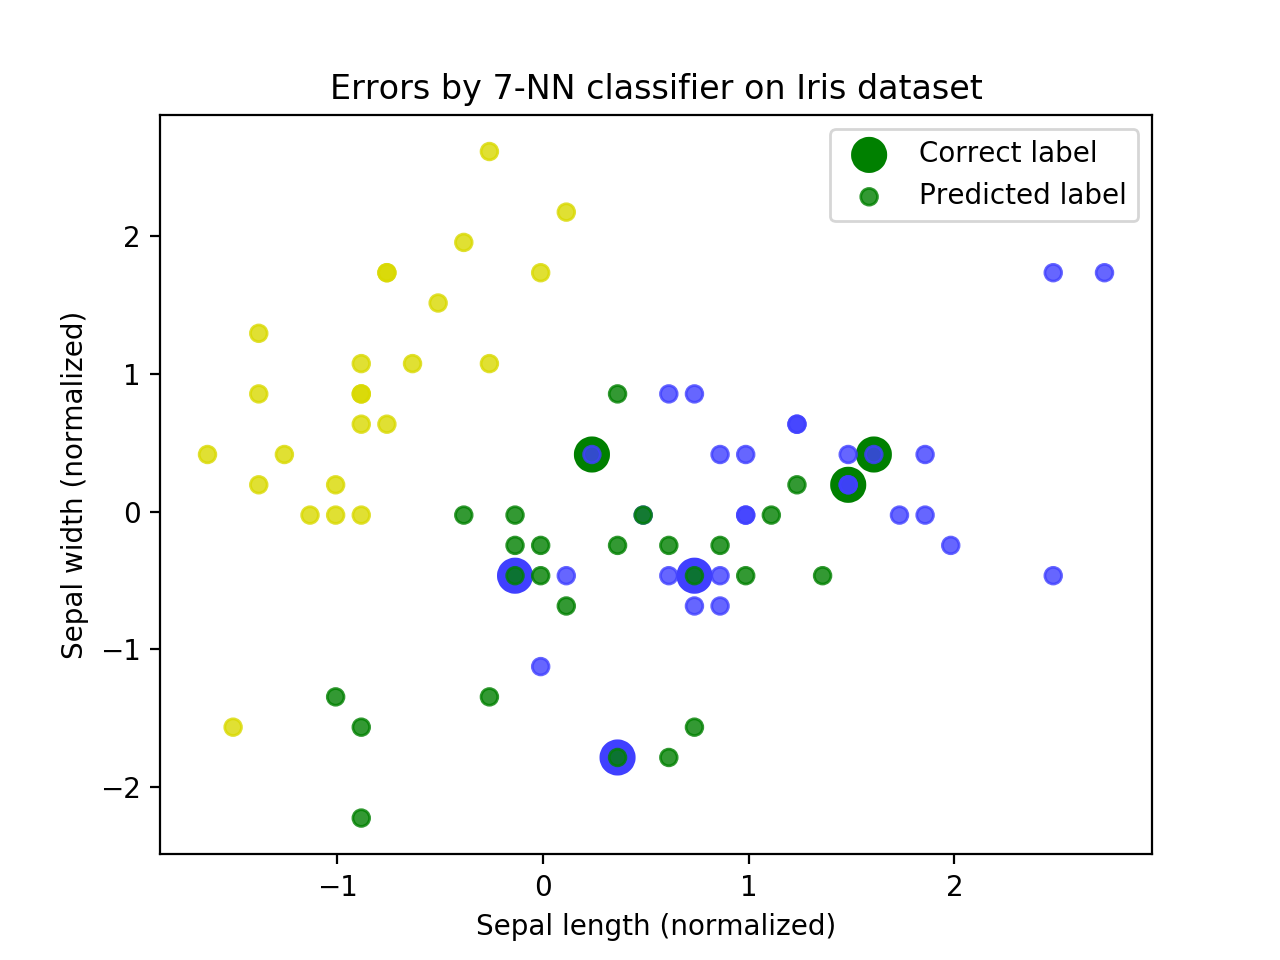

In [43]:
# Repeat the step above, but now plot Sepal length vs Sepal width.

selected_features = (0, 1)

plt.figure()
plt.title(f"Errors by {best_k}-NN classifier on Iris dataset")
plt.scatter(*iris_testing_features[incorrect_predictions][:, selected_features].T,
            c=colors[iris_testing_labels[incorrect_predictions]], lw=7, label='Correct label')
plt.scatter(*iris_testing_features[:, selected_features].T,
            c=colors[iris_testing_prediction], alpha=0.8, label='Predicted label')
plt.xlabel(iris_feature_names[selected_features[0]] + " (normalized)")
plt.ylabel(iris_feature_names[selected_features[1]] + " (normalized)")
plt.legend();

# Proximity less apparent.
# Difficult to visualize distances in high-dimensional data.

**Q. Do misclassifications occur where you would expect?**

> Here, mistakes do not seem to occur close to the class boundary. If we only had these two features at hand, the classification would be much more difficult. Fortunately we know not to alarm ourselves by this plot.

**Q. Why is this plot not consistent with the one above?**

> It is. Since the data is high-dimensional, and therefore difficult to visually interpret directly, we cannot draw conclusions about our results here.